In [36]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pydot
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
import geopandas as gpd
import warnings
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import random
import math
import time
import sklearn
import calendar
import matplotlib.dates as mdates
import matplotlib

In [37]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data_harvest = pd.read_csv('Data_final.csv', index_col = 0)
data_all = pd.read_csv('Data_all_final.csv', index_col = 0)
#data = gpd.read_file('Data_full_mandals.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [38]:
warnings.filterwarnings('ignore')

In [39]:
del data_harvest['geometry']
data_harvest = pd.merge(data_harvest, mandal_boundaries[['index', 'geometry']], how='left', on=['index'])

del data_all['geometry']
data_all = pd.merge(data_all, mandal_boundaries[['index', 'geometry']], how='left', on=['index'])


In [40]:
data_all = data_all.rename(columns = {'ModifiedDateTime': 'Date', 'Area_Crops': 'Crops_count', 'Area_Built_Area': 'Built_count', 'Built_Area_Prop': 'Built_Area_proportion', 'SoilT_Pellic_Luvisols': 'SoilT_majority_Pellic_Luvisols', 'Crops_Prop': 'Crops_proportion', 'SoilT_Chromic_Vertisols': 'SoilT_majority_Chromic_Vertisols',
       'SoilT_Eutric_Nitosols' : 'SoilT_majority_Eutric_Nitosols', 'SoilT_Lithosols': 'SoilT_majority_Lithosols', 'SoilT_Pellic_luvisols': 'SoilT_majority_Pellic_Luvisols', 'SoilT_Plinthic_Luvisols': 'SoilT_majority_Plinthic_Luvisols', 
       'SoilT_Vertic_Cambisols': 'SoilT_majority_Vertic_Cambisols', 'SoilT_Chromic_Luvisols': 'SoilT_majority_Chromic_Luvisols' })

In [41]:
data_all.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'Date', 'Year', 'Month', 'Fires',
       'FRP', 'Season', 'NO2', 'PM2.5', 'SSM_mean', 'SSM_median', 'SSM_min',
       'SSM_max', 'SSM_percentile_90', 'PRE_mean', 'PRE_median', 'PRE_min',
       'PRE_max', 'PRE_percentile_90', 'PRE_sum', 'POP_mean', 'POP_median',
       'ST_mean', 'ST_median', 'ST_min', 'ST_max', 'ST_percentile_90',
       'RWI_mean', 'RWI_median', 'RWI_min', 'RWI_max', 'RWI_percentile_90',
       'BA_mean', 'BA_median', 'BA_sum', 'Crops_count', 'Crops_proportion',
       'Area_Trees', 'Trees_Prop', 'Built_count', 'Built_Area_proportion',
       'PowP_score', 'Soil Type', 'Area', 'Harvested_CropA_Paddy',
       'Harvested_CropA_Maize', 'Harvested_CropA_Soybean',
       'Harvested_CropA_Cotton', 'Harvested_CropA_Chillies',
       'Harvested_CropA_Turmeric', 'SoilT_majority_Chromic_Luvisols',
       'SoilT_majority_Chromic_Vertisols', 'SoilT_majority_Eutric_Nitosols',
       'SoilT_majority_Lithosols', 'SoilT_majority_Pellic_Luvi

In [108]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
       # print(n_samples)
        k_fold_size = n_samples // self.n_splits
        print(k_fold_size)
        indices = np.arange(n_samples)
        print(indices)

        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int((self.n_splits-1)/self.n_splits * (stop - start)) + start
            yield indices[start: mid], indices[mid: stop]

In [110]:
BlockingTimeSeriesSplit(n_splits=4)

Model

In [43]:
def RandomForestRegressionModel(parameters_tuned_final, data, train_data, test_data, features_com, predictor, btscv):

    array_X = np.array(data[features_com])
    array_Y = np.array(data[predictor])

    MAE_folds = []
    R2_folds = []
    RMSE_folds = []
    MAPE_folds =[]
    accuracy_folds = []

    for train_index, test_index in btscv.split(array_X):

        
        #print('TRAIN:', train_index, 'TEST', test_index) 
        x_train, x_test = array_X[train_index], array_X[test_index]
        y_train, y_test = array_Y[train_index], array_Y[test_index]

        if parameters_tuned_final['max_features'] !='auto':
            parameters_tuned_final['max_features'] = int(len(features_com)/3)
            if parameters_tuned_final['max_features'] == 0:
                parameters_tuned_final['max_features'] = 1


        clf = RandomForestRegressor(n_estimators=parameters_tuned_final['n_estimators'], max_depth=parameters_tuned_final['max_depth'], bootstrap = parameters_tuned_final['bootstrap'], max_features = parameters_tuned_final['max_features'], min_samples_leaf = parameters_tuned_final['min_samples_leaf'], min_samples_split = parameters_tuned_final['min_samples_split'], random_state=0)

        #Fit to the training data
        clf.fit(x_train, y_train)

        #Make a prediction on the test data
        predictions = clf.predict(x_test)

        #Calculate mean absolute error
        MAE_folds.append(mean_absolute_error(y_test, predictions))
    
        #MAPE
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)

        # Calculate and display accuracy
        accuracy_folds.append(100 - np.mean(mape))

        #RMSE
        MSE_folds = np.square(np.subtract(y_test, predictions)).mean() 
        RMSE_folds.append(math.sqrt(MSE_folds))

        #R2
        R2_folds.append(r2_score(y_test, predictions))
        #print(R2_folds)

    
    clf_whole = RandomForestRegressor(n_estimators=parameters_tuned_final['n_estimators'], max_depth=parameters_tuned_final['max_depth'], bootstrap = parameters_tuned_final['bootstrap'], max_features = parameters_tuned_final['max_features'], min_samples_leaf = parameters_tuned_final['min_samples_leaf'], min_samples_split = parameters_tuned_final['min_samples_split'], random_state=0)
    #Fit to the training data
    clf_whole.fit(train_data[features_com], train_data[predictor])

    #Make a prediction on the test data
    predictions_whole = clf_whole.predict(test_data[features_com])

    MAE = [sum(MAE_folds)/len(MAE_folds), mean_absolute_error(test_data[predictor], predictions_whole)]
    RMSE = [sum(RMSE_folds)/len(RMSE_folds), math.sqrt(np.square(np.subtract(test_data[predictor], predictions_whole)).mean())]
    R2 = [sum(R2_folds)/len(R2_folds), r2_score(test_data[predictor], predictions_whole)]
    Accuracy = [sum(accuracy_folds)/len(accuracy_folds), 100 - np.mean(100 * ((abs(predictions_whole-test_data[predictor]))/test_data[predictor]))]



    return(clf_whole, MAE, RMSE, R2, Accuracy)

Feature Importances

In [44]:
def permutation_importances(rf_model, features_com, predictor, test_dataset):

    X_val = test_dataset[features_com]
    y_val = test_dataset[predictor]

    importances_info = permutation_importance(rf_model, X_val, y_val, n_repeats=30, random_state=0)

    importances = importances_info['importances_mean']
    importances_std = importances_info['importances_std']
    feature_importances = [(feature, round(importance, 15), importances_std) for feature, importance, importances_std in zip(features_com, importances, importances_std)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    names=[]
    values=[]
    values_std = []

    for i in range(0, len(importances)):
        names.append(feature_importances[i][0])
        values.append(feature_importances[i][1])
        values_std.append(feature_importances[i][2])

    plt.bar(names, values, yerr = values_std)
    plt.xticks(names, rotation='vertical')
    plt.ylim([0, 0.8])
    plt.ylabel('Decrease in R2', fontsize=12)
    plt.xlabel('Variable', fontsize=12)
    #plt.title('Permutation Importances', fontsize=20)
    plt.show()

    #print('Feature Importances: ' + str(feature_importances))

    return(feature_importances)

In [45]:
def SHAP_explainer(rf_model, train_dataset, features_com, predictor):
    rf_model = shap.TreeExplainer(rf_model)
    shap_values_rf_train = rf_model.shap_values(train_dataset[features_com])

    #plt.title('SHAP', fontsize=20 )
    shap.summary_plot(shap_values_rf_train, train_dataset[features_com])
    #shap.set_xlabels('SHAP Value (impact on model output)', fontsize=15)
    #shap.set_ylabels('Feature Value', fontsize=15)

    return()

Error Plots

In [77]:
def geo_error_plot(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit:str):


    test_dataset['Predictions'] = rf_model.predict(test_dataset[features_com])
    test_dataset['Errors'] = abs(test_dataset['Predictions'] - test_dataset[predictor])

    mandal_errors = test_dataset.groupby(['index'])[['Errors', 'Predictions', predictor]].mean().reset_index()
    mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

    mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

    mandal_errors.plot(column = 'Errors', legend=True, figsize = [12,6], legend_kwds = {'label': 'MAE: ' + unit}, cmap = 'RdYlGn_r')
    plt.axis('off')
    #plt.title('MAE', fontsize = 20)
    plt.show()


    best = mandal_errors.sort_values(by='Errors')['index'].iloc[0]
    print('Best Mandal: ' + str(best) + ' ' + mandal_boundaries[mandal_boundaries['index']==best]['Mandal_Nam'].iloc[0] + ' MAE:  '+ str(round(mandal_errors[mandal_errors['index']==best]['Errors'].iloc[0], 2)))
    worst = mandal_errors.sort_values(by='Errors')['index'].iloc[len(mandal_errors)-1]
    print('Worst Mandal: ' + str(worst) + ' ' + mandal_boundaries[mandal_boundaries['index']==worst]['Mandal_Nam'].iloc[0] + ' MAE: ' + str(round(mandal_errors[mandal_errors['index']==worst]['Errors'].iloc[0],2)))
    average_NO2 = 523
    average_PM25 = 101

    if predictor == 'NO2':
        average = average_NO2
    elif predictor == 'PM2.5':
        average = average_PM25

    print('Average Mandal: ' + str(average) + ' ' + mandal_boundaries[mandal_boundaries['index']==average]['Mandal_Nam'].iloc[0] + ' MAE: '+ str(round(mandal_errors[mandal_errors['index']==average]['Errors'].iloc[0],2)))

    best_mandal = test_dataset[test_dataset['index']==best]
    worst_mandal = test_dataset[test_dataset['index']==worst]
    avg_mandal = test_dataset[test_dataset['index']==average]
                
    myFmt = mdates.DateFormatter('%Y-%b') 
    
    n = 0
    ax = plt.subplot(1, 1, n + 1)

    ax.plot(best_mandal['Date'], best_mandal['Predictions'], c='lightgreen', marker='o')
    ax.plot(best_mandal['Date'], best_mandal[predictor], c='green', marker='o')
    ax.plot(worst_mandal['Date'], worst_mandal['Predictions'], c='salmon', marker='o')
    ax.plot(worst_mandal['Date'], worst_mandal[predictor], c='red', marker='o')
    ax.plot(avg_mandal['Date'], avg_mandal['Predictions'], c='lightblue', marker='o')
    ax.plot(avg_mandal['Date'], avg_mandal[predictor], c='blue', marker='o')
    ax.set_xlabel('Date', fontsize = 15)
    ax.set_ylabel(unit, fontsize = 15)
    #ax.set_title(predictor)
    ax.set_xticklabels(avg_mandal['Date'], rotation=45)
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend(['Best Predicted', 'Best Actual', 'Worst Predicted', 'Worst Actual', 'Average Predicted', 'Average Actual'])#, bbox_to_anchor=(0.75, 1)) 
    plt.show()   

    errors_per_date = test_dataset.groupby('Date')[['Errors', 'Predictions', predictor]].mean().reset_index()
                
    myFmt = mdates.DateFormatter('%Y-%b') 
    
    n = 0
    ax = plt.subplot(1, 1, n + 1)

    ax.plot(errors_per_date['Date'], errors_per_date['Errors'], c='r', marker='o')
    ax.plot(errors_per_date['Date'], errors_per_date['Predictions'], c='b', marker='o')
    ax.plot(errors_per_date['Date'], errors_per_date[predictor], c='g', marker='o')
    ax.set_xlabel('Date', fontsize = 15)
    ax.set_ylabel(unit, fontsize = 15)
    #ax.set_title(predictor)
    ax.set_xticklabels(errors_per_date['Date'], rotation=45)
    ax.xaxis.set_major_formatter(myFmt)
    ax.legend(['MAE', 'Predicted', 'Actual'])
    plt.show()

    return(mandal_errors)

In [47]:
def geo_actual_predicted(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit):

    #Predictions
    test_dataset['Predictions'] = rf_model.predict(test_dataset[features_com])

    mandal_errors = test_dataset.groupby(['index'])[['Predictions', predictor]].mean().reset_index()
    mandal_errors = pd.merge(mandal_errors, mandal_boundaries[['index', 'geometry']], on='index', how='left')

    mandal_errors = gpd.GeoDataFrame(mandal_errors,geometry = mandal_errors.geometry, crs = {'init': 'epsg:4326'}) 

    if predictor == 'NO2':
        min_range = 110
        max_range = 550
    elif predictor == 'PM2.5':
        min_range = 27
        max_range = 45

    ax = mandal_errors.plot(column = 'Predictions', legend=True, figsize = [12,6], legend_kwds = {'label': 'Predictions: ' + unit}, vmin=min_range, vmax=max_range, cmap = 'RdYlGn_r')   #110 550 voor no2
    fig = ax.figure
    cb_ax = fig.axes[1] 

    cb_ax.tick_params(labelsize=12)

    ax.axis('off')
    #plt.ylim([0,500])
    #plt.title('Predicted Values', fontsize = 20)
    plt.show()

    #Acutal
    ax = mandal_errors.plot(column = predictor, legend=True, figsize = [12,6], legend_kwds = {'label': 'Actual: ' + unit}, vmin=min_range, vmax=max_range, cmap='RdYlGn_r')
    fig = ax.figure
    cb_ax = fig.axes[1] 

    cb_ax.tick_params(labelsize=12)
    ax.axis('off')
    #plt.ylim([0,500])
    #plt.title('Actual Values', fontsize = 20)
    plt.show()

    return()

In [48]:
matplotlib.rcParams.update({'font.size': 12})

Define Optimal Models

In [49]:
features_NO2 = ['PowP_score',
 'RWI_mean',
 'SSM_percentile_90',
 'SoilT_majority_Pellic_Luvisols',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize',
 'POP_median',
 'Built_count',
 'PRE_max',
 'ST_max']


features_PM25 = ['PowP_score',
 'RWI_median',
 'SSM_median',
 'ST_max',
 'PRE_max',
 'Harvested_CropA_Paddy',
 'Harvested_CropA_Maize']


In [50]:
hyperparameters_NO2 = {'bootstrap': True, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 400}

hyperparameters_PM25 = {'bootstrap': True, 'max_depth': 7, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1400}

Data Split

In [51]:
data = data_all

data_all['Date'] = pd.to_datetime(data_all['Date'])

test = data_all[data_all['Date']>='2018-09-01']
train = data_all[data_all['Date']<'2018-09-01']

train = train.reset_index()
test = test.reset_index()

del train['level_0']
del test['level_0']

print(len(train), len(test))

13238 6825


NO2

In [52]:
clf_NO2, MAE_NO2, RMSE_NO2, R2_NO2, Accuracy_NO2 = RandomForestRegressionModel(hyperparameters_NO2, data, train, test, features_NO2, 'NO2', BlockingTimeSeriesSplit(n_splits = 4))
print('MAE: ' + str(MAE_NO2[1]) + '\n' + 'RMSE: ' + str(RMSE_NO2[1]) + '\n' + 'R2: ' + str(R2_NO2[1]) + '\n' + 'Accuracy: ' + str(Accuracy_NO2[1]))

MAE: 41.505027172434886
RMSE: 52.58045720677299
R2: 0.6843070672833196
Accuracy: 79.68812753159243


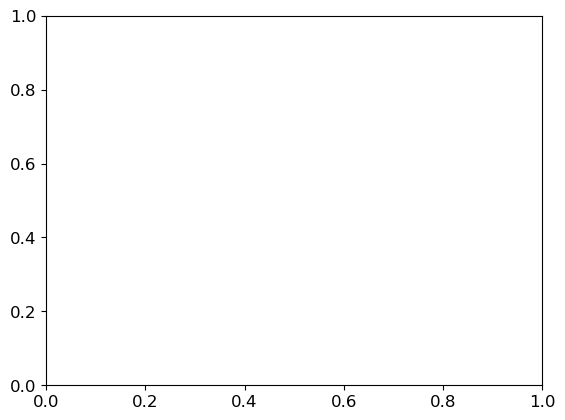

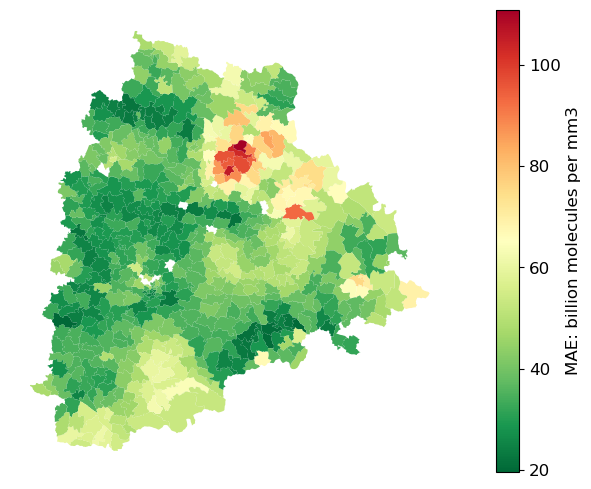

Best Mandal: 240 Kodangal MAE:  19.62
Worst Mandal: 578 Anthergaon MAE: 110.87
Average Mandal: 523 Valigonda MAE: 41.54


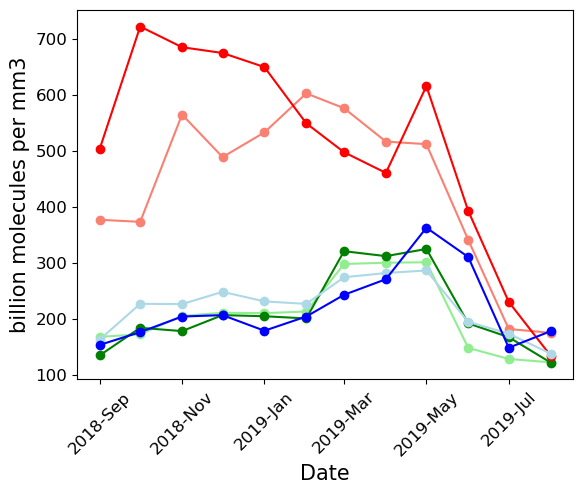

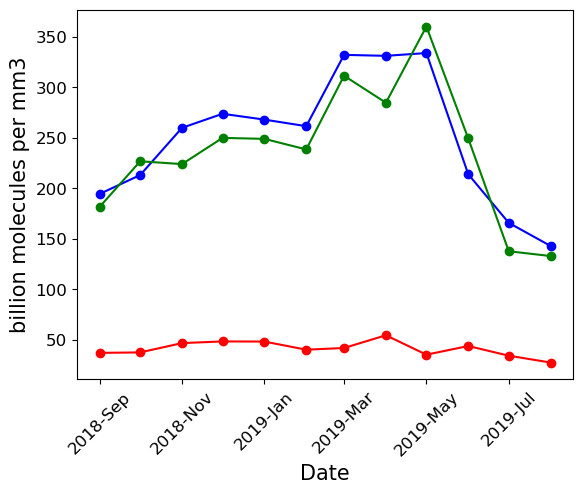

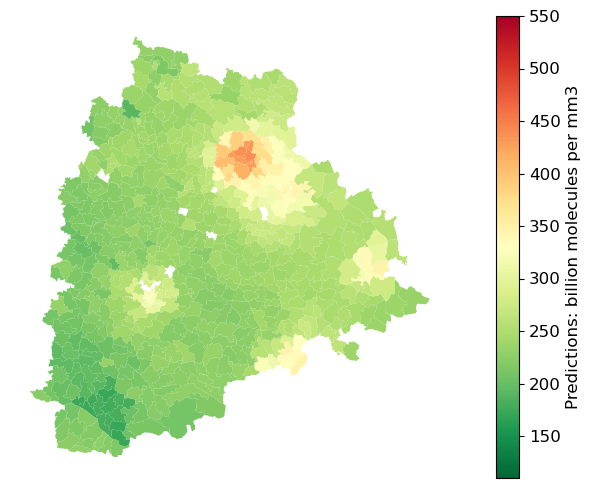

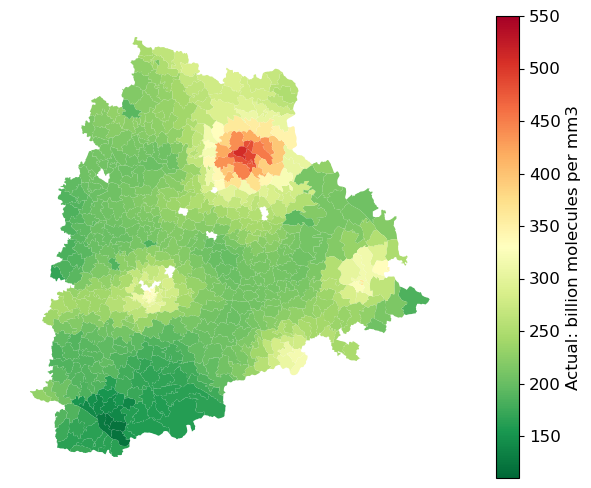

()

In [76]:
rf_model = clf_NO2
features_com = features_NO2
test_dataset = test
train_dataset = train
predictor = 'NO2'
unit = 'billion molecules per mm3'


permutation_importances(rf_model, features_com, predictor, test_dataset)
SHAP_explainer(rf_model, train_dataset, features_com, predictor)
df = geo_error_plot(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit)
geo_actual_predicted(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit)

PM25

In [54]:
clf_PM25, MAE_PM25, RMSE_PM25, R2_PM25, Accuracy_PM25 = RandomForestRegressionModel(hyperparameters_PM25, data, train, test, features_PM25, 'PM2.5', BlockingTimeSeriesSplit(n_splits = 4))
print('MAE: ' + str(MAE_PM25[1]) + '\n' + 'RMSE: ' + str(RMSE_PM25[1]) + '\n' + 'R2: ' + str(R2_PM25[1]) + '\n' + 'Accuracy: ' + str(Accuracy_PM25[1]))

MAE: 5.149405611226501
RMSE: 6.804065413335633
R2: 0.5912647777906043
Accuracy: 84.86063167139464


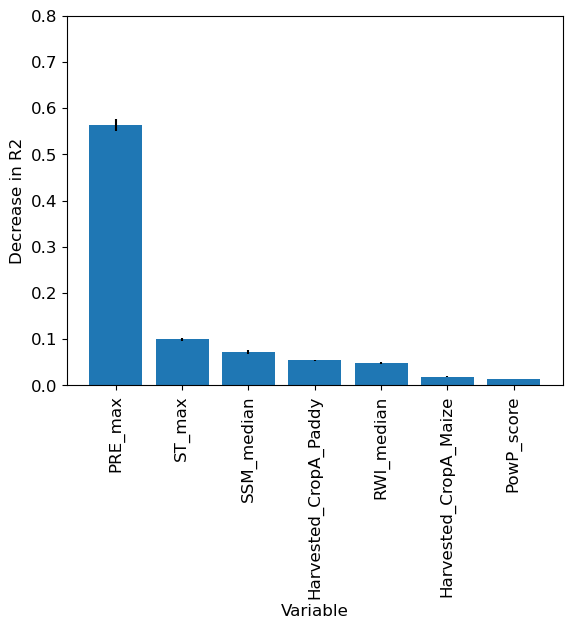

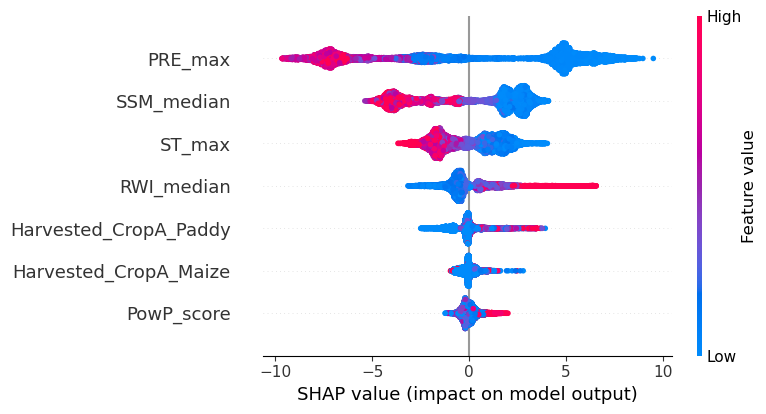

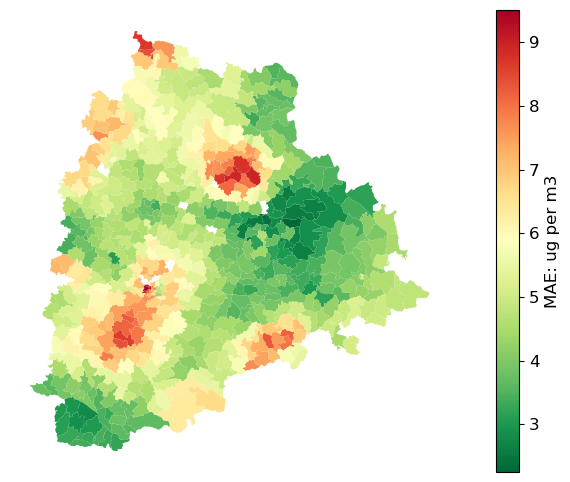

Best Mandal: 355 Nallabelli MAE:  2.25
Worst Mandal: 463 Shaikpet MAE: 9.51
Average Mandal: 101 Choutuppal MAE: 5.15


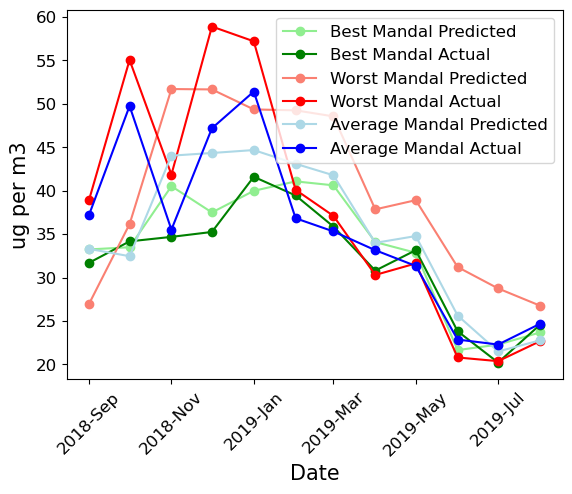

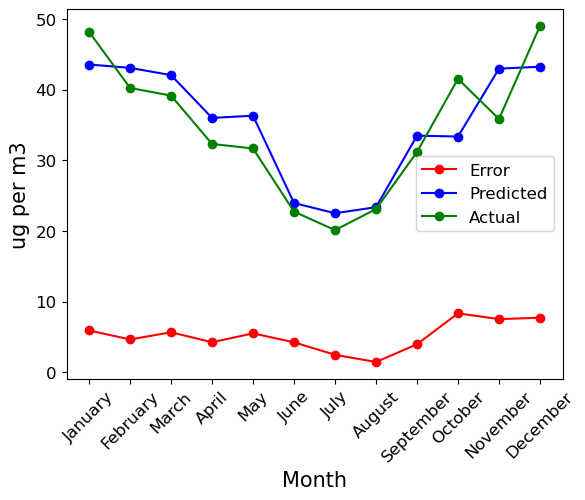

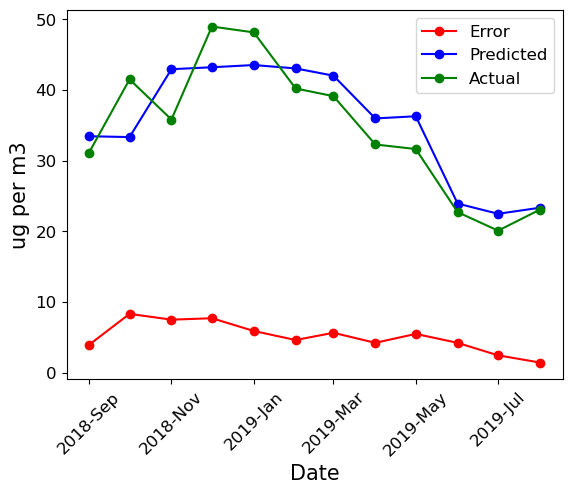

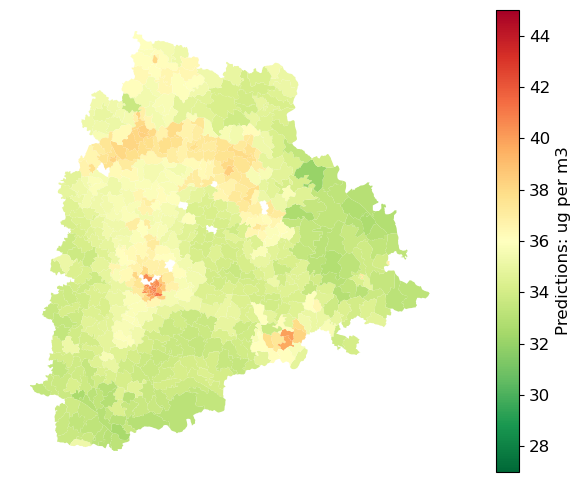

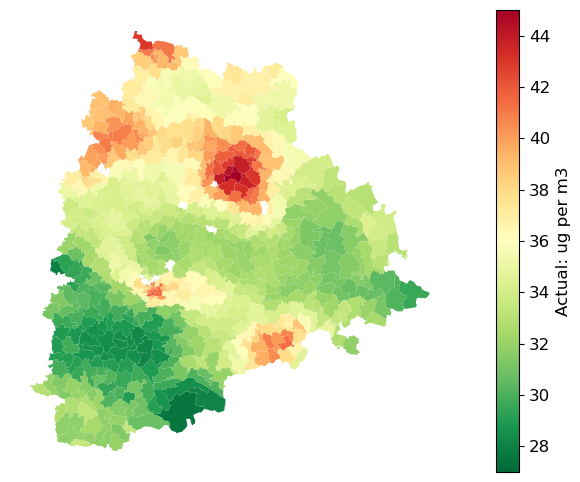

()

In [55]:
rf_model = clf_PM25
features_com = features_PM25
test_dataset = test
train_dataset = train
predictor = 'PM2.5'
unit = 'ug per m3'


permutation_importances(rf_model, features_com, predictor, test_dataset)
SHAP_explainer(rf_model, train_dataset, features_com, predictor)
df = geo_error_plot(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit)
geo_actual_predicted(rf_model, features_com, test_dataset, predictor, mandal_boundaries, unit)

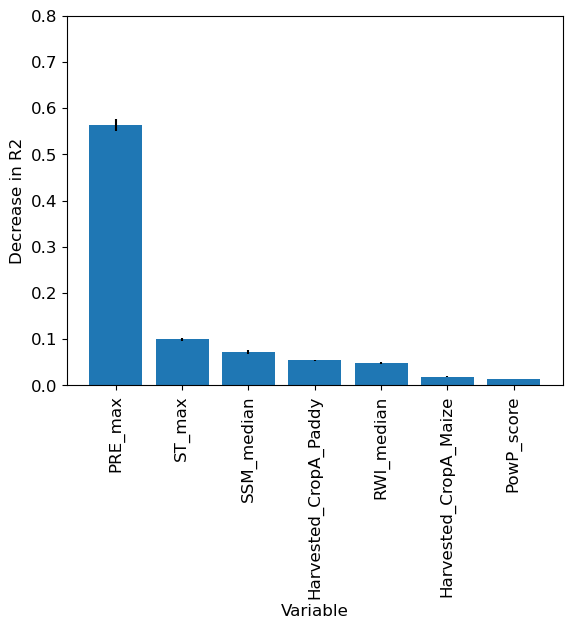

[('PRE_max', 0.56318567967774, 0.012787948769436586),
 ('ST_max', 0.099452735215601, 0.003324556290881409),
 ('SSM_median', 0.072144707930222, 0.004194882904621399),
 ('Harvested_CropA_Paddy', 0.054181799332, 0.00165573637170183),
 ('RWI_median', 0.047431720615886, 0.0021721685568195596),
 ('Harvested_CropA_Maize', 0.018997494318287, 0.0009729902916291325),
 ('PowP_score', 0.014010486019374, 0.0007502446676722567)]

In [80]:
rf_model = clf_PM25
features_com = features_PM25
test_dataset = test
train_dataset = train
predictor = 'PM2.5'
unit = 'ug per m3'


permutation_importances(rf_model, features_com, predictor, test_dataset)